In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
from src.data import MultiviewImgDataset, IFCNetPly, IFCNetNumpy
from src.models.models import MVCNN, SVCNN
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import transforms
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize

In [18]:
log_dir = Path(f"./logs/HybridModel")
log_dir.mkdir(exist_ok=True, parents=True)
data_root_gnn = Path('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings')
data_root_cnn = Path('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/MVCNN/IFCNetCore')

category_mapping = { # to sample matching IFCNetCore classes and ArcGNN categories
"Walls": "IfcWall",
"Furniture": "IfcFurniture",
"Doors": "IfcDoor",
"Windows": "IfcDoor", #not in IFC dataset
"Floors": "IfcWall", #not in IFC dataset
"Plumbing Fixtures": "IfcSanitaryTerminal",
"Structural Columns": "IfcBeam",
"Railings": "IfcRailing",
"Structural Framing": "IfcBeam", #not in IFC dataset
"Stairs": "IfcStair"
}    

with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

config = {
            "batch_size": 1,
            "cnn_name": "vgg11",
            "epochs": 30,
            "learning_rate": 1.3529557841712963e-05,
            "num_views": 12,
            "pretrained": True,
            "weight_decay": 0.00019094898290886048
        }

batch_size = config["batch_size"]
learning_rate = config["learning_rate"]
weight_decay = config["weight_decay"]
pretrained = config["pretrained"]
cnn_name = config["cnn_name"]
num_views = config["num_views"]
epochs = config["epochs"]
class_names = list(category_mapping.values())
num_classes = len(class_names)

In [19]:

svcnn_model = SVCNN(num_classes, pretrained=True, cnn_name=cnn_name) 
model_state, _ = torch.load('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/MVCNN_pretrained/SVCNNWeights+Optimizer3')
svcnn_model.load_state_dict(model_state)

model = MVCNN(svcnn_model, num_classes, num_views=num_views, cnn_name=cnn_name)
model_state, _ = torch.load('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/MVCNN_pretrained/MVCNNWeights+Optimizer0')
model.load_state_dict(model_state)



<All keys matched successfully>

In [33]:
def cnn_collate_fn(batch):
    cnn_data_list = []
    cnn_labels = []


    for cnn_data in batch:
        if cnn_data is not None:
            cnn_data_list.append(cnn_data[0])  # Assuming mvcnn_data is a tuple of (data, label)
            cnn_labels.append(cnn_data[1])

    # Batch MVCNN data
    if len(cnn_data_list) == 0:
        return None, None

    cnn_batch = torch.stack(cnn_data_list)
    print('cnn_batch',cnn_batch)
    print('cnn_batch.shape',cnn_batch.shape)
    cnn_labels = torch.tensor(cnn_labels, dtype=torch.long)
    print('cnn_labels',cnn_labels)

    return cnn_batch, cnn_labels

In [34]:
transform = [
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]
transform = transforms.Compose(transform)

def cnn_collate_fn(batch):
    cnn_data_list = []
    cnn_labels = []


    for cnn_data in batch:
        if cnn_data is not None:
            cnn_data_list.append(cnn_data[0])  # Assuming mvcnn_data is a tuple of (data, label)
            cnn_labels.append(cnn_data[1])

    # Batch MVCNN data
    if len(cnn_data_list) == 0:
        return None

    cnn_batch = torch.stack(cnn_data_list)
    cnn_labels = torch.tensor(cnn_labels, dtype=torch.long)

    return cnn_batch, cnn_labels


train_dataset = MultiviewImgDataset(data_root, class_names, 12, partition="train", transform=transform)
val_dataset = MultiviewImgDataset(data_root, class_names, 12, partition="train", transform=transform)
test_dataset = MultiviewImgDataset(data_root, class_names,12, partition="test", transform=transform)

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.7 * len(train_dataset))
train_dataset = Subset(train_dataset, perm[:train_len])
val_dataset = Subset(val_dataset, perm[train_len:])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=cnn_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, num_workers=0, collate_fn=cnn_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=0, collate_fn=cnn_collate_fn)

In [35]:
device = 'cpu' #torch.device("cuda")
model.to(device)

MVCNN(
  (net_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [38]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(map(lambda x: x[3:], display_labels))
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []
    idx = 0

    with torch.no_grad():
        for data, labels in tqdm(loader):
            if data == None:
                continue
                
            idx += 1
            data, labels = data.to(device), labels.to(device)
            data = data.view(-1, *data.shape[-3:])

            outputs = model(data)

            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())
            
            if idx == 1000:
                break

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

In [39]:
eval(model, train_loader, device, class_names)

  0%| | 2/486 [00:09<39:21,  4.88s


TypeError: cannot unpack non-iterable NoneType object

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [29:23<00:00,  8.44s/it]
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([19, 14, 17, ..., 19, 19,  2]),
 array([[2.5376682e-03, 5.0196266e-03, 5.8952807e-03, ..., 1.3409332e-04,
         5.9282960e-04, 2.1845984e-01],
        [1.7947374e-01, 6.6566356e-03, 5.7049792e-02, ..., 7.8900787e-04,
         1.8554076e-03, 5.4779468e-04],
        [3.7111987e-03, 2.9071474e-02, 4.3817400e-03, ..., 7.9927305e-03,
         1.3646840e-01, 2.9329367e-05],
        ...,
        [3.7634883e-03, 1.3419108e-02, 3.7767116e-02, ..., 1.6571094e-04,
         1.0990225e-03, 4.3982729e-02],
        [6.0143736e-03, 6.7310233e-04, 7.5644436e-03, ..., 2.1785523e-05,
         6.9971713e-05, 5.8630395e-01],
        [2.8024704e-04, 7.3546156e-02, 8.6856329e-01, ..., 4.3235256e-04,
         9.2914887e-03, 1.1396412e-04]], dtype=float32))

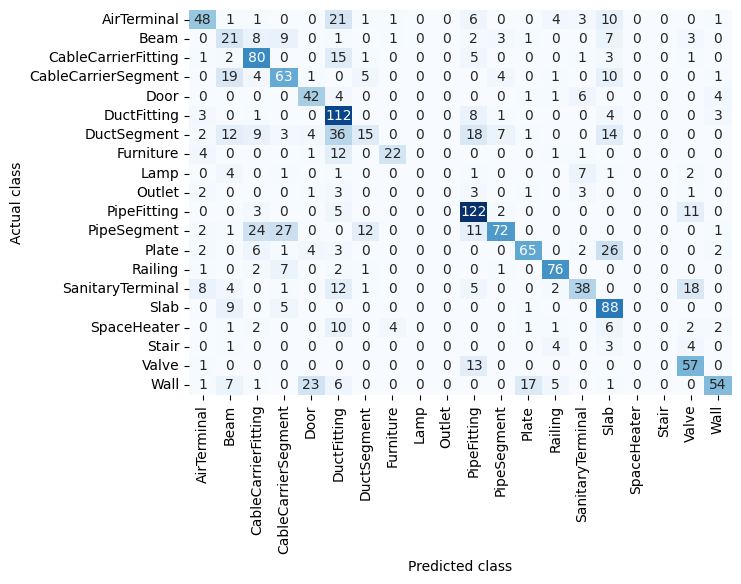

In [11]:
eval(model, val_loader, device, class_names)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298/298 [41:52<00:00,  8.43s/it]
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


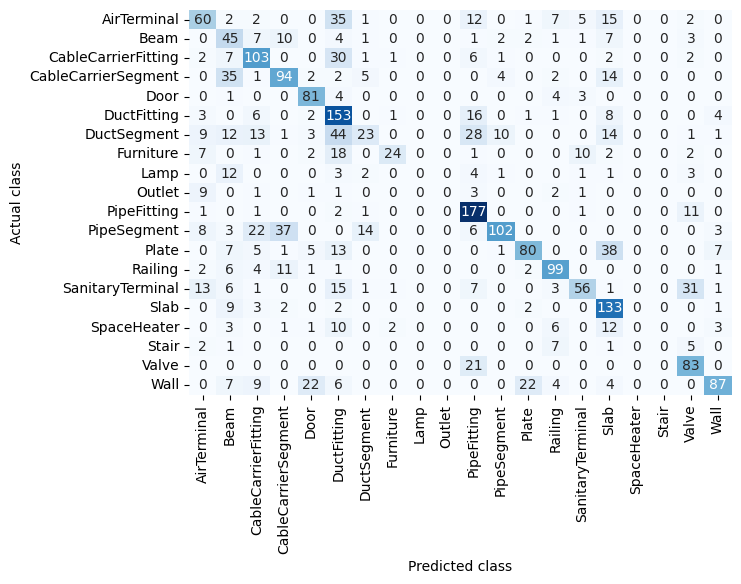

In [14]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/mvcnn_confusion.png")

In [15]:
np.savez("MVCNNProbs.npz", labels=test_labels, probs=test_probs)

In [16]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]

In [17]:
wrong_pred_dir = Path("../data/external/MVCNN/wrong_classes/IFCNetCore")
raw_data_dict = {path.stem: path for path in Path("../data/raw/IFCNetCore").glob("**/test/*.obj")}
wrong_pred_dir.mkdir(parents=True, exist_ok=True)
for i in wrong_predictions:
    label_str = class_names[test_labels[i]]
    prediction_str = class_names[test_predictions[i]]
    print(f"{test_dataset.filepaths[i][0].stem[:-2]}, Label: {label_str}, Prediction: {prediction_str}")
    target_dir = wrong_pred_dir / label_str
    target_dir.mkdir(exist_ok=True)
    filename = test_dataset.filepaths[i][0]
    shutil.copy(str(raw_data_dict[filename.stem[:-2]]), str(target_dir / f"{filename.stem[:-2]}_{prediction_str}.obj"))

0040c7bf0e474141bb19bdf8ed59e080, Label: IfcAirTerminal, Prediction: IfcValve


KeyError: '0040c7bf0e474141bb19bdf8ed59e080'